In [1]:
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, Lambda, SimpleRNN
import matplotlib.pyplot as plt 
import pandas_datareader as web
import statsmodels.api as sm  
plt.style.use('fivethirtyeight')

In [2]:
from os.path import dirname
dirPath = dirname(dirname(os.getcwd()))+"\codec\TotalCleanedTest.csv"
dirPath
df = pd.read_csv(dirPath)
df['ent_regis'] = df['ent_regis'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_resid'] = df['ent_resid'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_ocurr'] = df['ent_ocurr'].apply(lambda x: '{0:0>2}'.format(x))
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,ent_regis,ent_regis_nm,mun_regis,mun_regis_nm,ent_resid,ent_resid_nm,mun_resid,mun_resid_nm,ent_ocurr,ent_ocurr_nm,...,lengua,loc_ocur,ICD,detailCaus,Organ,ICD_Mex,detailCaus_Mex,organ_Mex,date_ocurr,month_year_ocurr
0,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,NaN,NaN,C25,Tumor maligno de la cabeza del páncreas,Pancreas,C25,Tumor maligno del páncreas,Pancreas,2010-01-11,2010-01-01
1,01,Aguascalientes,1002,Asientos,01,Aguascalientes,1002,Asientos,01,Aguascalientes,...,NaN,NaN,C22,"Tumor maligno del hígado, no especificado",Liver,C22,Tumor maligno del hígado y de las vías biliare...,Liver,2010-01-05,2010-01-01
2,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,...,NaN,NaN,C34,"Tumor maligno de los bronquios o del pulmón, p...",Lungs,C34,"Tumor maligno de la tráquea, de los bronquios ...",Lungs,2010-01-14,2010-01-01
3,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,...,NaN,NaN,C49,Tumor maligno de parte especificada del peritoneo,Soft Tissue,C49,Tumores malignos de los tejidos mesoteliales y...,Soft Tissue,2010-01-20,2010-01-01
4,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,...,NaN,NaN,C20,"Tumor maligno del colon, parte no especificada",Colon and Rectum,C20,Tumor maligno del colon,Colon and Rectum,2010-01-27,2010-01-01


In [3]:
def getTimeSeries(state):
    if state == '00':
        dff = df
        series = dff['date_ocurr'].value_counts().rename_axis('unique_values').reset_index(name='counts')
        series = series.sort_values(by=['unique_values'])
        series.reset_index(inplace=True)
        series = series.drop(columns=['index'])
        return series        
    else:
        dff = df.loc[(df['ent_regis'] == state)]
        series = dff['date_ocurr'].value_counts().rename_axis('unique_values').reset_index(name='counts')
        series = series.sort_values(by=['unique_values'])
        series.reset_index(inplace=True)
        series = series.drop(columns=['index'])
        return series

In [4]:
def TimeSeriesSmoothing(series):
    data = series.filter(['counts'])
    dataset = data.values
    dataset = dataset.astype('float32')
    cycle, trend = sm.tsa.filters.hpfilter(series.counts, 1600)
    gdp_decomp = series[['counts']]
    gdp_decomp["cycle"] = cycle
    gdp_decomp["trend"] = trend
    trend = gdp_decomp[["trend"]]
    cut = trend.size - 25
    trend = trend[:cut]
    return trend

In [15]:
def preprocessing(trend):
    data = trend.filter(['trend'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset)*.85)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    train_data = scaled_data[0:training_data_len,:]
    look_backs = 90
    
    x_train = []
    y_train = []

    for i in range(look_backs, len(train_data)):
        x_train.append(train_data[i-look_backs:i,0])
        y_train.append(train_data[i,0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return (scaled_data, x_train, y_train)

In [16]:
def def_model():
    model = Sequential() #initialize sequential model
    model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
    model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
    model.add(LSTM(32)) #LSTM layer with 32 neurons
    model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
    model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
    model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
    model.compile(loss='mse', optimizer='Adam', metrics=['mae'])
    return model

In [17]:
def get_predictions(scaled_data, series, look_backs, model):
    data = series.filter(['trend'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset)*.85)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(series)

    test_data = scaled_data[training_data_len - look_backs: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(look_backs, len(test_data)):
        x_test.append(test_data[i-look_backs:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    train = series[:training_data_len]
    valid = series[training_data_len:]
    valid['Predictions'] = predictions
    rmse = np.sqrt(np.mean(predictions-y_test)**2)
    return valid, rmse

In [34]:
series = getTimeSeries('31')

In [35]:
smoothedSeries = TimeSeriesSmoothing(series)

In [36]:
s_data, x_train, y_train = preprocessing(smoothedSeries)

In [37]:
model = def_model()
model.fit(x_train,y_train,batch_size=1,epochs=1)

2925/2925 [==============================] - 126s 41ms/step - loss: 0.0052 - mae: 0.0468


In [41]:
valid, rmse = get_predictions(s_data, smoothedSeries, 75, model)

<ipython-input-17-5fc36c476ba9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [42]:
rmse

0.0014137826372439752

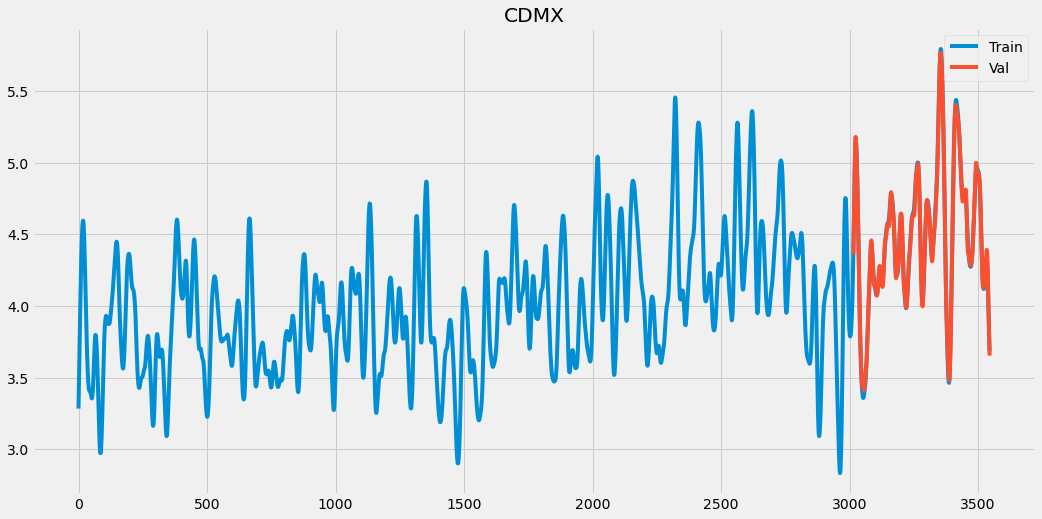

In [43]:
fig1 = plt.figure(figsize=(16,8))
plt.title("CDMX")
plt.plot(smoothedSeries[["trend"]])
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [44]:
def continueSeries(series):
    predictions = []
    df1 = series.filter(['trend'])
    dff = df1
    add = df1.shape[0]
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(series)
    count = 0
    while(1):
        if count == 15:
            break
        else:
            last_60_days = dff[-75:].values
            last_60_days_scaled = scaler.transform(last_60_days)
            X_test = []
            #Append the last 60 days
            X_test.append(last_60_days_scaled)
            #convert to a numpy array
            X_test = np.array(X_test)
            #reshape the data
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
            #Get the predicted scaled value
            pred_val = model.predict(X_test)
            pred_cases = scaler.inverse_transform(pred_val)
            df1.loc[add+count+1] = pred_cases[0][0]
            dff = df1
            count = count+1
    return df1

In [45]:
continuedSeries = continueSeries(smoothedSeries)

In [46]:
print(f"{smoothedSeries.shape}, {continuedSeries.shape}")

(3546, 1), (3561, 1)


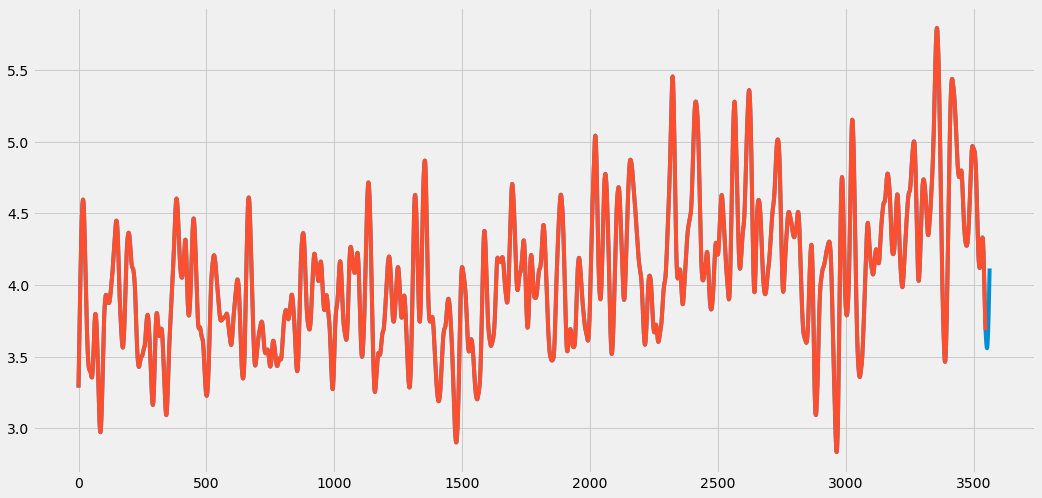

In [47]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(continuedSeries)
plt.plot(smoothedSeries[["trend"]])
plt.show()


In [48]:
from IPython.display import clear_output
for i in range (0,11,1):
    print(f"iteration: {i}\n")
    s_data, x_train, y_train = preprocessing(continuedSeries)
    model = def_model()
    model.fit(x_train,y_train,batch_size=1,epochs=1)
    valid = get_predictions(s_data, continuedSeries, 75, model)
    continuedSeries = continueSeries(continuedSeries)
    clear_output(wait=True)

iteration: 10

3065/3065 [==============================] - 121s 38ms/step - loss: 0.0089 - mae: 0.0584
<ipython-input-17-5fc36c476ba9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


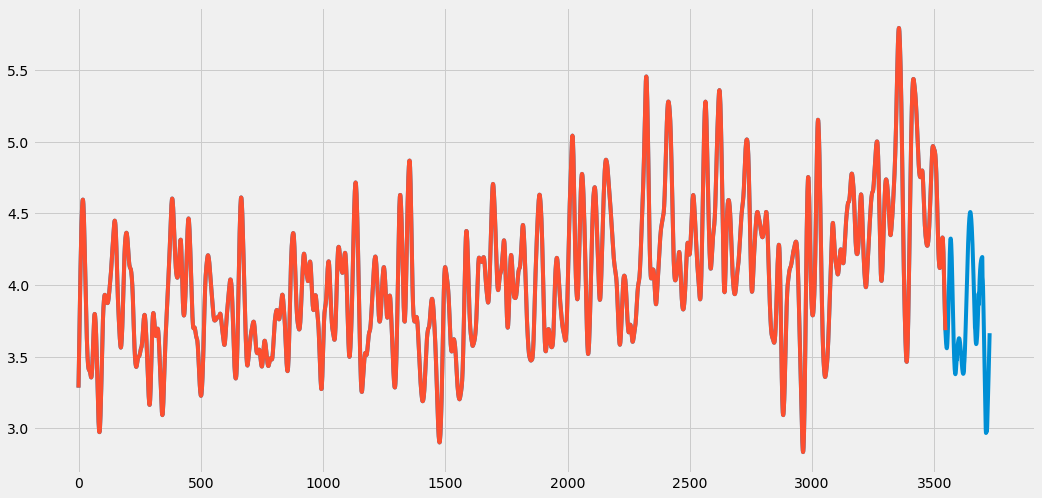

In [49]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(continuedSeries)
plt.plot(smoothedSeries[["trend"]])
plt.show()

In [50]:
pPath = os.getcwd()+'\\resultsCSV\\31.csv'
continuedSeries.to_csv(pPath)
pPath

'c:\\Users\\David Fernandez\\Desktop\\cancerDataAnalysis\\RNN_Notebooks\\RNN\\resultsCSV\\31.csv'

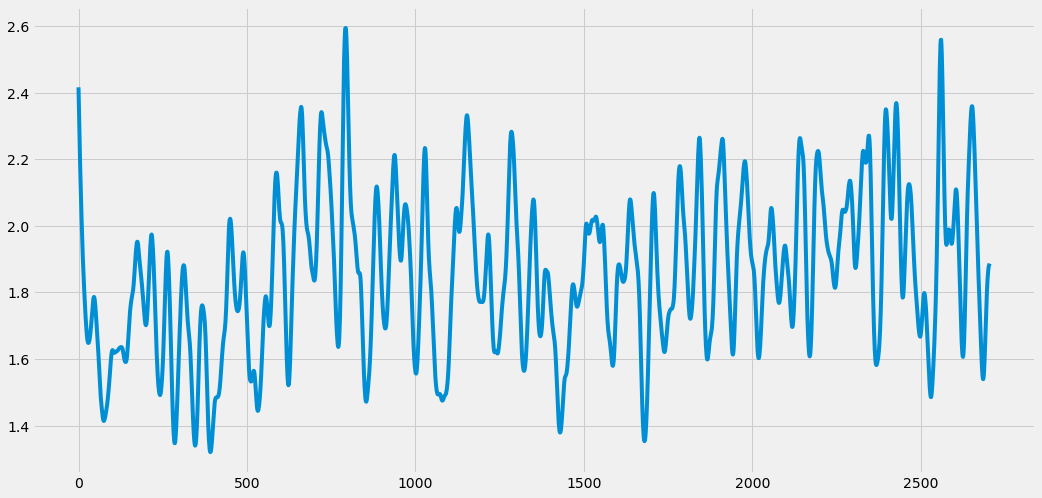

In [52]:
fig1 = plt.figure(figsize=(16,8))
h = continuedSeries.shape[0] - (12*15)
plt.plot(continuedSeries[:h])

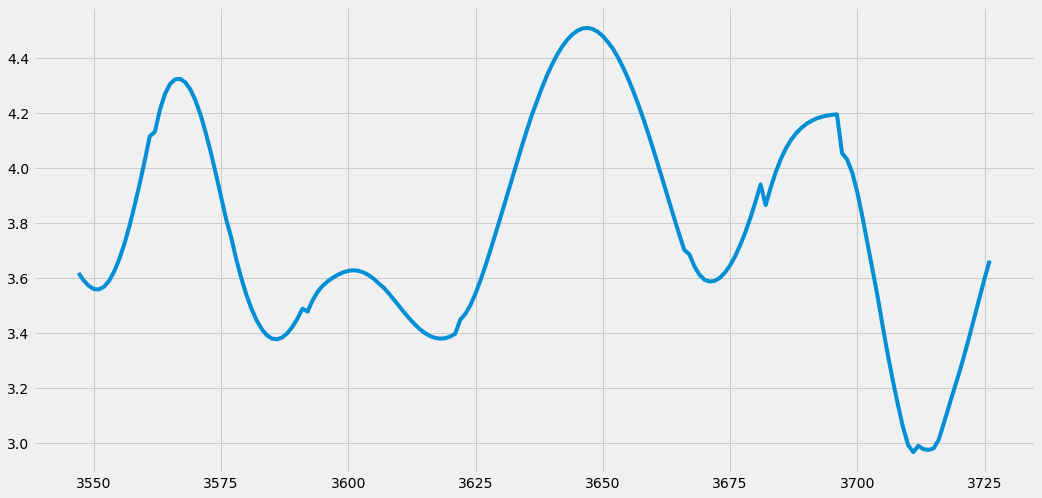

In [51]:
fig1 = plt.figure(figsize=(16,8))
h = continuedSeries.shape[0] - (12*15)
plt.plot(continuedSeries[h:])